<img src="julia-computing.svg" width="200">

# Miletus: Pricing Analytics in Julia
### Simon Byrne


_Miletus_ is a Julia package providing:
1. a flexible contract definition language, and
2. a library of automatically adapted valuation routines.

The implementation leverages many of Julia's powerful features:
- Generic programming and multiple dispatch
- Aggressive JIT compiler
- Fast user-defined types
- Extensive third-party libraries for features such as automatic differentiation (AD)


In [1]:
using Miletus
using Base.Dates
using Miletus.TermStructure
using Miletus.DayCounts
using BusinessDays
using Gadfly, Colors

import Miletus: When, Give, Receive, Buy, Both, At, Either, Zero
import Miletus: YieldModel, maturitydate
import Miletus.TermStructure: ConstantContinuousYieldCurve
import BusinessDays: USGovernmentBond

## Contract specification language

Miletus contracts are composed from basic "primitive" elements.

Inspired by the work of Simon Peyton Jones and Jean-Marc Eber: "How to write a financial contract".

In [2]:
Receive(100)

Amount
 └─100


In [3]:
Give(Receive(100))

Give
 └─Amount
    └─100


In [4]:
Pay(100)

Give
 └─Amount
    └─100


In [5]:
Pay(100USD)

Give
 └─Amount
    └─100USD


In [6]:
s = SingleStock()

SingleStock


In [7]:
Buy(s, 100USD)

Both
 ├─SingleStock
 └─Give
    └─Amount
       └─100USD


In [8]:
ZCB(Date("2017-12-25"), 100USD)

When
 ├─{==}
 │  ├─DateObs
 │  └─2017-12-25
 └─Amount
    └─100USD


In [9]:
Either(SingleStock(), Zero())

Either
 ├─SingleStock
 └─Zero


In [10]:
eucall = EuropeanCall(Date("2017-12-25"), s, 100USD)

When
 ├─{==}
 │  ├─DateObs
 │  └─2017-12-25
 └─Either
    ├─Both
    │  ├─SingleStock
    │  └─Give
    │     └─Amount
    │        └─100USD
    └─Zero


In [11]:
amput = AmericanPut(Date("2017-12-25"), SingleStock(), 100USD)

Anytime
 ├─{<=}
 │  ├─DateObs
 │  └─2017-12-25
 └─Either
    ├─Both
    │  ├─Give
    │  │  └─SingleStock
    │  └─Amount
    │     └─100USD
    └─Zero


## Models

A contract captures the fixed/objective parameters
 - e.g. strike price, maturity date

A `Model` captures the varying/subjective parameters
 - spot price, discount rate, implied volatility

#### Yield Curves & Dates

Miletus contains implementations of basic interest rate fundamentals, such as compounding rules, day count fractions, and holiday calendars. 

In [12]:
yc = ConstantContinuousYieldCurve(Actual365(), .1,Dates.today())

Constant Continuous Curve with r = 0.1, T = 2017-03-16 

In [13]:
ym = YieldModel(yc, ModFollowing(), USGovernmentBond())

Miletus.YieldModel{Miletus.TermStructure.ConstantContinuousYieldCurve{Miletus.DayCounts.Actual365,Float64},Miletus.DayCounts.ModFollowing,BusinessDays.USGovernmentBond}

In [14]:
value(ym, ZCB(Date("2017-12-25"), 100USD))

92.48884051943325USD

### Geometric Brownian Motion 

The workhorse model of quant finance

\begin{equation}
    dS_t = \mu \, S_t \, dt + \sigma \,S_t \,dW_t
\end{equation}

In [15]:
m = GeomBMModel(today(), 100.0USD, 0.1, 0.05, .15)

Geometric Brownian Motion Model
-------------------------------
S₀ = 100.0USD
T = 2017-03-16
Yield Constant Continuous Curve with r = 0.1, T = 2017-03-16 
Carry Constant Continuous Curve with r = 0.05, T = 2017-03-16 
σ = 0.15


The `value` function computes the present value of a contract under the assumptions of a model.

In [16]:
value(m, SingleStock())

100.0USD

In [17]:
value(m, Buy(SingleStock(),80USD))

20.0USD

In [18]:
value(m, When(At(Date("2017-12-25")),Buy(SingleStock(),80USD)))

22.172946904477428USD

Many of these valuations can be automated by certain propeties:
* `value(m, Give(c))       == -value(m, c)`
* `value(m, Both(c1,c2))   ==  value(m, c1) + value(m,c2)`
* `value(m, Either(c1,c2)) == max(value(m, c1), value(m,c2))`

These can all be handled via Julia's powerful multiple dispatch mechanism.

In other cases, we can recognise when known closed-form expressions exist, e.g. the Black&ndash;Scholes model:

In [19]:
value(m, eucall)

7.024932107415285USD

Using inconsistent units will throw an error

In [20]:
# Valuing GBP contract with a USD model
value(m, EuropeanCall(Date("2017-12-25"), s, 100GBP)) 

LoadError: MethodError: no method matching isless(::Miletus.Currency.CurrencyQuantity{Miletus.Currency.CurrencyUnit{:GBP},Float64}, ::Miletus.Currency.CurrencyQuantity{Miletus.Currency.CurrencyUnit{:USD},Float64})[0m
Closest candidates are:
  isless([1m[31m::DataArrays.NAtype[0m, ::Any) at /Users/simon/.julia/v0.5/DataArrays/src/operators.jl:510
  isless{U}(::Miletus.Currency.CurrencyQuantity{U,T<:Real}, [1m[31m::Miletus.Currency.CurrencyQuantity{U,T<:Real}[0m) at /Users/simon/.julia/v0.5/Miletus/src/currency.jl:54
  isless(::Any, [1m[31m::DataArrays.NAtype[0m) at /Users/simon/.julia/v0.5/DataArrays/src/operators.jl:511[0m

Not all contracts can be easily valued, e.g.

In [21]:
value(m, amput)

LoadError: MethodError: no method matching value(::Miletus.GeomBMModel{Miletus.CoreModel{Miletus.Currency.CurrencyQuantity{Miletus.Currency.CurrencyUnit{:USD},Float64},Miletus.TermStructure.ConstantContinuousYieldCurve{Miletus.DayCounts.Actual365,Float64},Miletus.TermStructure.ConstantContinuousYieldCurve{Miletus.DayCounts.Actual365,Float64}},Float64}, ::Miletus.Anytime{Miletus.LiftObs{Base.#<=,Tuple{Miletus.DateObs,Miletus.ConstObs{Date}},Bool},Miletus.Either{Miletus.Both{Miletus.Give{Miletus.SingleStock},Miletus.Amount{Miletus.ConstObs{Miletus.Currency.CurrencyQuantity{Miletus.Currency.CurrencyUnit{:USD},Int64}}}},Miletus.Zero}})[0m
Closest candidates are:
  value(::Miletus.GeomBMModel{C,V}, ::Miletus.Contract, [1m[31m::Type{Miletus.MonteCarloModel}[0m, [1m[31m::Integer[0m) at /Users/simon/.julia/v0.5/Miletus/src/models/montecarlo.jl:126
  value(::Miletus.GeomBMModel{C,V}, ::Miletus.Contract, [1m[31m::Type{Miletus.LeastSquaresMonteCarlo}[0m, [1m[31m::Integer[0m, [1m[31m::Integer[0m) at /Users/simon/.julia/v0.5/Miletus/src/models/lsmc.jl:34
  value(::Miletus.AbstractModel, [1m[31m::Miletus.DateObs[0m) at /Users/simon/.julia/v0.5/Miletus/src/models/abstractmodel.jl:5
  ...[0m

### Binomial Lattice Models

These are discretisations of the geometric Brownian motion:

In [22]:
# Cox-Ross-Rubinstein model
crrm  = CRRModel(today(), Date("2017-12-25"), 1000, 100.0USD, 0.1, 0.05, 0.15) 

Miletus.BinomialGeomRWModel{Miletus.Currency.CurrencyQuantity{Miletus.Currency.CurrencyUnit{:USD},Float64},Float64,Float64}

In [23]:
value(crrm, eucall)

7.023638130674357USD

In [24]:
value(crrm, amput)

3.8040118404200087USD

<img src="quantlib.png"/>

In [25]:
function quantlib_am_put_crr(S,K,r,c,σ,dt1::Date,dt2::Date, n)
    ccall((:ql_am_put_crr, "/Users/simon/.julia/v0.5/Miletus/benchmarks/quantlib"), Cdouble,
          (Cdouble, Cdouble, Cdouble, Cdouble, Cdouble,
           Cint, Cint, Cint,
           Cint, Cint, Cint,
           Cint),
          S, K, r, c, σ,
          year(dt1), month(dt1), day(dt1),
          year(dt2), month(dt2), day(dt2),
          n)
end

quantlib_am_put_crr (generic function with 1 method)

In [26]:
quantlib_am_put_crr(100,100,0.1, 0.05, 0.15,Dates.today(), Date("2017-12-25"),1000)

3.80402826971833

In [27]:
@time value(crrm, amput)

  0.009043 seconds (130 allocations: 15.703 KB)


3.8040118404200087USD

In [28]:
@time quantlib_am_put_crr(100,100,0.1, 0.05, 0.15,Dates.today(), Date("2017-12-25"),1000)

  0.026918 seconds (53 allocations: 2.078 KB)


3.80402826971833

### Valuation using Monte Carlo

In [29]:
# Simulate from the geometric Brownian motion
mcm = Miletus.montecarlo(m, today():Date("2017-12-25"), 10_000) 

Monte Carlo Model
-----------------
10000 Simulations everyday from 2017-03-16 to 2017-12-25
S₀ = 100.0USD
Yield Constant Continuous Curve with r = 0.1, T = 2017-03-16 
Carry Constant Continuous Curve with r = 0.05, T = 2017-03-16 
σ = 0.15


In [30]:
theme=Theme(default_color=Colors.RGBA{Float32}(0.1, 0.1, 0.7, 0.1))
plot_paths(mcm, r) = 
plot([layer(x=mcm.dates,y=mcm.paths[i,:]./USD,Geom.line,theme) for i = r]..., 
Guide.ylabel("USD"),Guide.xlabel("t"))

plot_paths (generic function with 1 method)

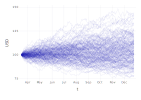

In [31]:
plot_paths(mcm,1:200)

In [32]:
value(mcm, eucall)

7.033411203103609USD

#### Asian Options

In [33]:
# Asian fixed strike option based on average of the past month
asian = AsianFixedStrikeCall(Date("2017-12-25"), SingleStock(), Dates.Month(1), 100.00USD)

When
 ├─{==}
 │  ├─DateObs
 │  └─2017-12-25
 └─Either
    ├─Both
    │  ├─MovingAveragePrice
    │  │  ├─SingleStock
    │  │  └─1 month
    │  └─Give
    │     └─Amount
    │        └─100.0USD
    └─Zero


In [34]:
value(mcm, asian)

6.727457283813901USD

## Other features

### Volatility curve fitting

In [35]:
strikes = 46.50:0.50:48.50
contracts = [EuropeanCall(Date("2017-11-25"), SingleStock(), K) for K in strikes]
prices = [2.24,1.95,1.69,1.45,1.23]

core = CoreModel(Date("2017-11-01"), 47.32, 0.0, 0.0)

ivols = ivol.([core], contracts, prices)

5-element Array{Float64,1}:
 0.375322
 0.370226
 0.366849
 0.363018
 0.3587  

Can fit more complex models such as the SABR:

In [36]:
sabr = fit(SABRModel, core, contracts, prices)

Miletus.SABRModel{Float64}

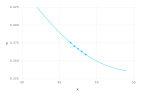

In [37]:
x_strikes = 42.00:0.50:54.00
xcontracts = [EuropeanCall(Date("2017-11-25"), SingleStock(), K) for K in x_strikes]

plot(
    layer(x=x_strikes, y=ivol.([sabr],xcontracts), Geom.line),
    layer(x=strikes, y=ivols, Geom.point))

## Greeks

Miletus computes derivatives using _automatic differentiation_. This is significantly quicker, and more accurate, compared to the usual finite differencing techniques. 

In [38]:
delta(m, eucall)

0.6162010305644144

In [39]:
vega(m, eucall)

31.721630111302836USD

In [40]:
vega(mcm, eucall)  # using Monte Carlo model

31.694121385562752USD

In [41]:
vega(mcm, asian)    # vega of an Asian option

31.017771400189133USD

# JuliaFin/Miletus

Available to try out now:

http://juliacomputing.com/products/juliafin.html

## Define your own contracts using these primitives

In [39]:
function butterfly_call(expiry::Date, K₁, K₂, K₃)
    @assert K₁ < K₂ < K₃
    c₁ = EuropeanCall(expiry, SingleStock(), K₁)
    c₂ = EuropeanCall(expiry, SingleStock(), K₂)
    c₃ = EuropeanCall(expiry, SingleStock(), K₃)
    Both(Both(c₁,c₃), Give(Both(c₂,c₂)))
end

butterfly_call (generic function with 1 method)

In [40]:
function payoff_curve(c, d::Date, prices)
    payoff = [value(GeomBMModel(d, x, 0.0, 0.0, 0.0), c) for x in prices] 
    p = [x.val for x in payoff]
    r = [x.val for x in prices]
    return r, p
end

payoff_curve (generic function with 1 method)

In [41]:
expirydate = Date("2017-12-25")
startdate  = Date("2017-12-1")
interestrate = 0.05
carryrate    = 0.1
volatility   = 0.15
K₁ = 98.0USD  
K₂ = 100.0USD
K₃ = 102.0USD
L  = 11 # Layers in the binomial lattice / Number of time steps
price = K₁-1USD:0.1USD:K₃+1USD

call₁ = EuropeanCall(expirydate, SingleStock(), K₁)
call₂ = EuropeanCall(expirydate, SingleStock(), K₂)
call₃ = EuropeanCall(expirydate, SingleStock(), K₃)
s₁,cp₁ = payoff_curve(call₁, expirydate, price)
s₂,cp₂ = payoff_curve(call₂, expirydate, price)
s₃,cp₃ = payoff_curve(call₃, expirydate, price)


([97.0,97.1,97.2,97.3,97.4,97.5,97.6,97.7,97.8,97.9  …  102.1,102.2,102.3,102.4,102.5,102.6,102.7,102.8,102.9,103.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])

In [42]:
bfly₁ = butterfly_call(expirydate, K₁, K₂, K₃)

Both
 ├─Both
 │  ├─When
 │  │  ├─{==}
 │  │  │  ├─DateObs
 │  │  │  └─2017-12-25
 │  │  └─Either
 │  │     ├─Both
 │  │     │  ├─SingleStock
 │  │     │  └─Give
 │  │     │     └─Amount
 │  │     │        └─98.0USD
 │  │     └─Zero
 │  └─When
 │     ├─{==}
 │     │  ├─DateObs
 │     │  └─2017-12-25
 │     └─Either
 │        ├─Both
 │        │  ├─SingleStock
 │        │  └─Give
 │        │     └─Amount
 │        │        └─102.0USD
 │        └─Zero
 └─Give
    └─Both
       ├─When
       │  ├─{==}
       │  │  ├─DateObs
       │  │  └─2017-12-25
       │  └─Either
       │     ├─Both
       │     │  ├─SingleStock
       │     │  └─Give
       │     │     └─Amount
       │     │        └─100.0USD
       │     └─Zero
       └─When
          ├─{==}
          │  ├─DateObs
          │  └─2017-12-25
          └─Either
             ├─Both
             │  ├─SingleStock
             │  └─Give
             │     └─Amount
             │        └─100.0USD
             └─Zero


In [43]:
blk = colorant"black"
red = colorant"red"
grn = colorant"green"
blu = colorant"blue"
s,p_bfly₁ = payoff_curve(bfly₁, expirydate, price)


([97.0,97.1,97.2,97.3,97.4,97.5,97.6,97.7,97.8,97.9  …  102.1,102.2,102.3,102.4,102.5,102.6,102.7,102.8,102.9,103.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])

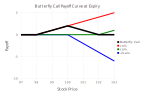

In [44]:
plot(layer( x=s ,y=p_bfly₁,Geom.line,Theme(default_color=blk,line_width=1.5mm)),
            layer( x=s₁,y=  cp₁  ,Geom.line,Theme(default_color=red,line_width=1.0mm)),
            layer( x=s₃,y=  cp₃  ,Geom.line,Theme(default_color=grn,line_width=1.0mm)),
            layer( x=s₂,y=-2cp₂  ,Geom.line,Theme(default_color=blu,line_width=1.0mm)),
            Guide.manual_color_key("",["Butterfly Call", "call₁", "call₃", "-2call₂"],
            ["black", "red", "green", "blue"]),
            Guide.title("Butterfly Call Payoff Curve at Expiry"),
            Guide.xlabel("Stock Price"), Guide.ylabel("Payoff"))

In [45]:
gbmm = GeomBMModel(startdate, K₂, interestrate, carryrate, volatility)
value(gbmm, bfly₁)

0.4024557323265583USD

In [46]:
# Buy a call at the high strike
# Sell a call at the low strike
function bear_call(expiry::Date, K₁, K₂)
    @assert K₁ != K₂
    c₁ = EuropeanCall(expiry, SingleStock(), K₁)
    c₂ = EuropeanCall(expiry, SingleStock(), K₂)
    Both(Give(c₁), c₂)
end


bear_call (generic function with 1 method)

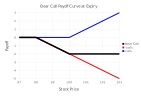

In [47]:
bear₁ = bear_call(expirydate, K₁, K₂)
s,p_bear₁ = payoff_curve(bear₁, expirydate, price)
blk = colorant"black"
red = colorant"red"
blu = colorant"blue"
plot(layer( x=s, y=p_bear₁,Geom.line,Theme(default_color=blk,line_width=1.5mm)),
     layer( x=s₁,y=-cp₁   ,Geom.line,Theme(default_color=red,line_width=1.0mm)),
     layer( x=s₂,y= cp₂   ,Geom.line,Theme(default_color=blu,line_width=1.0mm)),
     Guide.manual_color_key("",["Bear Call", "-call₁", "call₂"], 
     ["black", "red", "blue"]),
     Guide.title("Bear Call Payoff Curve at Expiry"), 
Guide.xlabel("Stock Price"), Guide.ylabel("Payoff"))

In [48]:
value(gbmm, bear₁)

-1.119680404537255USD

In [49]:
function couponbond(par,coupon,periods::Int,start::Date,expiry::Date)
    duration = expiry - start
    bond = When(At(expiry), Receive(par))
    for p = periods-1:-1:1
        coupondate = start + duration*p/periods 
        bond = Both(bond,When(At(coupondate), Receive(coupon)))
    end
    return bond
end

couponbond (generic function with 1 method)

In [50]:
par = 100USD
 coupon = 1USD
 periods = 12
 startdate = today()
expirydate = today() + Day(360)

2018-03-09

In [51]:
cpb = couponbond(par,coupon,periods,startdate,expirydate)

Both
 ├─Both
 │  ├─Both
 │  │  ├─Both
 │  │  │  ├─Both
 │  │  │  │  ├─Both
 │  │  │  │  │  ├─Both
 │  │  │  │  │  │  ├─Both
 │  │  │  │  │  │  │  ├─Both
 │  │  │  │  │  │  │  │  ├─Both
 │  │  │  │  │  │  │  │  │  ├─Both
 │  │  │  │  │  │  │  │  │  │  ├─When
 │  │  │  │  │  │  │  │  │  │  │  ├─{==}
 │  │  │  │  │  │  │  │  │  │  │  │  ├─DateObs
 │  │  │  │  │  │  │  │  │  │  │  │  └─2018-03-09
 │  │  │  │  │  │  │  │  │  │  │  └─Amount
 │  │  │  │  │  │  │  │  │  │  │     └─100USD
 │  │  │  │  │  │  │  │  │  │  └─When
 │  │  │  │  │  │  │  │  │  │     ├─{==}
 │  │  │  │  │  │  │  │  │  │     │  ├─DateObs
 │  │  │  │  │  │  │  │  │  │     │  └─2018-02-07
 │  │  │  │  │  │  │  │  │  │     └─Amount
 │  │  │  │  │  │  │  │  │  │        └─1USD
 │  │  │  │  │  │  │  │  │  └─When
 │  │  │  │  │  │  │  │  │     ├─{==}
 │  │  │  │  │  │  │  │  │     │  ├─DateObs
 │  │  │  │  │  │  │  │  │     │  └─2018-01-08
 │  │  │  │  │  │  │  │  │     └─Amount
 │  │  │  │  │  │  │  │  │        └─1USD
 │  │  

In [52]:
value(ym, cpb)

101.08069872619976USD